## Introduction


## Setup

In [1]:
!sudo apt-get update -y
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
#!pip install imageio
!pip install "imageio>=2.33,<2.35"
!pip install pyvirtualdisplay
!pip install pyglet
!pip install tf-agents[reverb]
!pip install gymnasium

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [79.8 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,801 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,040 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:13 https:/

In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb
import os

import tensorflow as tf

from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
#from tf_agents.networks import ActorNetwork, CriticNetwork
from tf_agents.networks import network
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
import gymnasium as gym 
from tf_agents.trajectories import time_step as ts

2025-06-28 05:59:29.497040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-28 05:59:29.497092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-28 05:59:29.498716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/r

In [3]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [4]:
tf.version.VERSION

'2.15.1'

## Hyperparameters
| Parámetro                           | Comentario                                                                              |
| ----------------------------------- | --------------------------------------------------------------------------------------- |
| `num_iterations = 20000`            | 20k pasos es razonable para ver progreso. Se puede aumentar.			        |
| `initial_collect_steps = 1000`      | Está bien para llenar el buffer inicialmente.                                           |
| `collect_steps_per_iteration = 1`   | Está bien para DDPG, que se entrena cada paso.                                          |
| `replay_buffer_max_length = 100000` | Más que suficiente.				                                        |
| `batch_size = 64`                   | Estándar y funciona bien. Se puede probar 128.    	                                |
| `learning_rate = 1e-3`              | Común para DDPG. Si el entrenamiento es inestable, prueba 1e-4.                         |
| `log_interval = 200`                | Bueno para monitorear progreso.                                                         |
| `num_eval_episodes = 10`            | Correcto para promediar bien el desempeño.                                              |
| `eval_interval = 500`               | Evaluar cada 500 pasos es razonable. Puedes hacerlo cada 1000 si quieres menos ruido.   |


In [5]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 500  # @param {type:"integer"}

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

Load the Pendulum environment from the OpenAI Gym suite.

In [6]:
# Nombre del entorno
env_name = 'Pendulum-v1'

# Cargar entorno de entrenamiento y evaluación
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# Convertir a entornos de TensorFlow
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Verificar especificaciones
print("Observación:", train_env.observation_spec())
print("Acción:", train_env.action_spec())

Observación: BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='observation', minimum=array([-1., -1., -8.], dtype=float32), maximum=array([1., 1., 8.], dtype=float32))
Acción: BoundedTensorSpec(shape=(1,), dtype=tf.float32, name='action', minimum=array(-2., dtype=float32), maximum=array(2., dtype=float32))


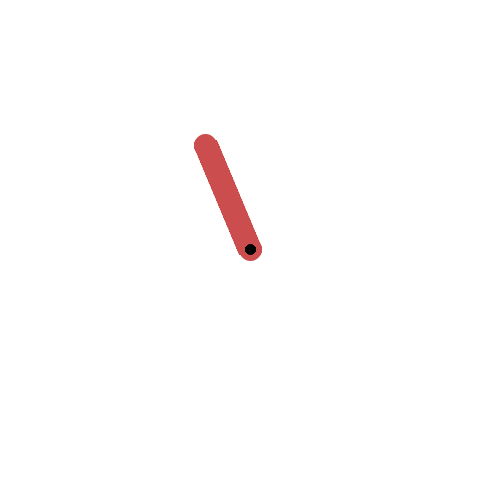

In [7]:
# Cargar entorno Gymnasium con render_mode adecuado
render_env = gym.make("Pendulum-v1", render_mode="rgb_array")

# Reiniciar entorno
render_env.reset()

# Renderizar una imagen y mostrarla
img = render_env.render()
PIL.Image.fromarray(img)

The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.


In [8]:
print('Observation Spec:')
print(train_env.observation_spec())

Observation Spec:
BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='observation', minimum=array([-1., -1., -8.], dtype=float32), maximum=array([1., 1., 8.], dtype=float32))


This describes the observation space — the input to your RL agent.

* Shape: (3,) → the observation is a 3D vector.

* Meaning of components:
    1. cos(θ) → pendulum angle in cosine form.
    2. sin(θ) → same angle in sine form.
    3. θ_dot → angular velocity of the pendulum.

* Values are bounded:
    1. cos/sin are between -1 and 1
    2. angular velocity is between -8 and 8

In [9]:
print('Reward Spec:')
print(train_env.reward_spec())

Reward Spec:
TensorSpec(shape=(), dtype=tf.float32, name='reward')


This means each time step will return a scalar reward (float32). No bounds are specified, but you know from Pendulum-v1’s definition that:

* Reward is typically negative.

* Maximum reward (0) happens when the pendulum is upright and still.

* Worst case is around -16.

In [10]:
print('Action Spec:')
print(train_env.action_spec())

Action Spec:
BoundedTensorSpec(shape=(1,), dtype=tf.float32, name='action', minimum=array(-2., dtype=float32), maximum=array(2., dtype=float32))


This is your action space — what the agent can do.

* It's a single continuous action in [-2.0, 2.0].
* This represents the torque applied to the pendulum motor.

In [11]:
# Reiniciar entorno
time_step = render_env.reset()
print('Time step:')
print(time_step)

# Tomar acción continua (en el rango permitido, e.g., [-2.0] a [2.0])
action = np.array([0.5], dtype=np.float32)

# Ejecutar un paso en el entorno
next_time_step = render_env.step(action)
print('Next time step:')
print(next_time_step)


Time step:
(array([-0.9399606 , -0.341283  ,  0.89122134], dtype=float32), {})
Next time step:
(array([-0.9272505, -0.3744416,  0.7102591], dtype=float32), -7.882264640204304, False, False, {})


Time step:
This is the observation returned when the environment is reset. It contains:

* An initial observation: cos(θ), sin(θ), θ_dot
* An empty dictionary {} — often used for metadata in newer Gymnasium versions.

Next time step:
This is what you get after taking one action (0.5 torque):

* Observation → new state of the system.
* Reward → -0.83 (negative: it’s not upright yet).
* Terminated → False (no terminal condition was reached).
* Truncated → False (the episode hasn’t hit max steps).
* Info dict → {} — again, often unused unless specific settings require it.

In [12]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [13]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

**Summary**
| What        | Meaning                                       |
| ----------- | --------------------------------------------- |
| Obs. Spec   | Your agent sees a 3D vector (cosθ, sinθ, θ̇)  |
| Action Spec | Agent outputs a float torque ∈ \[-2, 2]       |
| Reward      | Negative unless pendulum is upright and still |
| Step Output | Observation, reward, done flags, info dict    |


## Agent

The algorithm used to solve an RL problem is represented by an `Agent`. TF-Agents provides standard implementations of a variety of `Agents`, including:

-   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)
-   [REINFORCE](https://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
-   [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
-   [TD3](https://arxiv.org/pdf/1802.09477.pdf)
-   [PPO](https://arxiv.org/abs/1707.06347)
-   [SAC](https://arxiv.org/abs/1801.01290)

`Pendulum-v1` has a continuous action space:
`BoundedTensorSpec(shape=(1,), dtype=tf.float32, minimum=-2.0, maximum=2.0)`
This rules out standard DQN (Deep Q-Network), which is only suitable for discrete action spaces. DQN outputs one Q-value per possible action, which doesn't work when the action is a float like 0.35 or -1.2.

**What is DDPG?**

Deep Deterministic Policy Gradient (DDPG) is an actor-critic algorithm designed for continuous control tasks. It combines:

* A deterministic actor that outputs a specific continuous action.
* A critic that estimates the Q-value of (state, action) pairs.

DDPG is a model-free, off-policy RL algorithm based on:
* Deep Q-Learning ideas
* Deterministic Policy Gradient (DPG) theorem


In [14]:
#hiperparametros de la red
actor_fc_layers = (400, 300)
critic_fc_layers = (400, 300) 
critic_obs_fc_layers = (400,)
critic_action_fc_layers = (300,)
critic_joint_fc_layers = (300,)

In [15]:
#obtener las especificaciones
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()
time_step_spec = train_env.time_step_spec()

In [16]:
class CriticWrapper(network.Network):
    def __init__(self, observation_spec, action_spec, model, name='CriticWrapper'):
        input_tensor_spec = (observation_spec, action_spec)
        super().__init__(input_tensor_spec=input_tensor_spec, state_spec=(), name=name)
        self._model = model

    def call(self, inputs, step_type=None, network_state=(), training=False):
        observations, actions = inputs
        obs_shape = tf.shape(observations)
        obs_rank = tf.rank(observations)

        def with_time_dim():
            batch_size = obs_shape[0]
            seq_len = obs_shape[1]
            obs_flat = tf.reshape(observations, (batch_size * seq_len, -1))
            act_flat = tf.reshape(actions, (batch_size * seq_len, -1))
            q_flat = self._model([obs_flat, act_flat], training=training)
            return tf.reshape(q_flat, (batch_size, seq_len, 1)), network_state

        def no_time_dim():
            batch_size = tf.shape(observations)[0]
            q = self._model([observations, actions], training=training)
            return tf.reshape(q, (batch_size, 1)), network_state

        return tf.cond(
            tf.equal(obs_rank, 3),
            true_fn=with_time_dim,
            false_fn=no_time_dim
        )



class ActorWrapper(network.Network):
    def __init__(self, observation_spec, action_spec, model, name='ActorWrapper'):
        super().__init__(input_tensor_spec=observation_spec, state_spec=(), name=name)
        self._model = model

    def call(self, observation, step_type=None, network_state=(), training=False):
        obs_shape = tf.shape(observation)
        obs_rank = tf.rank(observation)

        def apply_time_dist():
            batch_size = obs_shape[0]
            seq_len = obs_shape[1]
            obs_dim = obs_shape[-1]
            obs_flat = tf.reshape(observation, (batch_size * seq_len, obs_dim))
            actions_flat = self._model(obs_flat, training=training)
            return tf.reshape(actions_flat, (batch_size, seq_len, -1))

        def apply_no_time_dist():
            return self._model(observation, training=training)

        actions = tf.cond(
            tf.equal(obs_rank, 3),
            true_fn=apply_time_dist,
            false_fn=apply_no_time_dist
        )

        return actions, network_state



In [17]:
def create_actor_model(observation_spec, action_spec, fc_layer_params=(400, 300)):
    inputs = tf.keras.Input(shape=observation_spec.shape)
    x = inputs
    for units in fc_layer_params:
        x = tf.keras.layers.Dense(units, activation='relu')(x)
    outputs = tf.keras.layers.Dense(action_spec.shape[0], activation='tanh')(x)  # asumir rango [-1,1]
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [18]:
def create_critic_network(observation_spec, action_spec, fc_layer_params=(400, 300)):
    obs_input = tf.keras.Input(shape=observation_spec.shape)
    action_input = tf.keras.Input(shape=action_spec.shape)
    concat = tf.keras.layers.Concatenate()([obs_input, action_input])
    x = concat
    for units in fc_layer_params:
        x = tf.keras.layers.Dense(units, activation='relu')(x)
    q_value = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=[obs_input, action_input], outputs=q_value)


# --- Construcción del agente ---
actor_model = create_actor_model(observation_spec, action_spec, actor_fc_layers)
target_actor_model = create_actor_model(observation_spec, action_spec, actor_fc_layers)
critic_model = create_critic_network(observation_spec, action_spec, critic_fc_layers)
target_critic_model = create_critic_network(observation_spec, action_spec, critic_fc_layers)

actor_net = ActorWrapper(observation_spec, action_spec, actor_model)
target_actor_net = ActorWrapper(observation_spec, action_spec, target_actor_model)
critic_net = CriticWrapper(observation_spec, action_spec, critic_model)
target_critic_net = CriticWrapper(observation_spec, action_spec, target_critic_model)

In [19]:
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_step_counter = tf.Variable(0)

agent = ddpg_agent.DdpgAgent(
    time_step_spec,
    action_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=actor_optimizer,
    critic_optimizer=critic_optimizer,
    ou_stddev=0.2,
    ou_damping=0.15,
    target_actor_network=target_actor_net,
    target_critic_network=target_critic_net,
    target_update_tau=0.005,
    target_update_period=1,
    gamma=0.99,
    train_step_counter=train_step_counter
)

agent.initialize()

El agente DDPG crea internamente redes objetivo (target networks) como copias de las redes principales (actor y crítico).

Cuando usas modelos funcionales de Keras dentro de wrappers personalizados (ActorWrapper, CriticWrapper), es posible que el agente intente copiar el wrapper pero termine compartiendo variables con el modelo original, lo cual no está permitido.

Para evitar esto:

1. Se crean funciones constructoras (build_actor_model, build_critic_model) que generan nuevas instancias del modelo Keras.

2. Se generan dos modelos independientes para cada red (actor y crítico): uno para la red principal y otro para la red objetivo.

3. Cada modelo se envuelve en su propio wrapper (ActorWrapper o CriticWrapper).

4. Se pasa explícitamente la red objetivo al agente DDPG usando los parámetros:

target_actor_network

target_critic_network

Así, el agente trabaja con redes independientes que no comparten pesos entre sí, evitando el error y permitiendo entrenar correctamente.

## Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.


Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.


In [20]:
# Política entrenada (DDPG)
eval_policy = agent.policy

# Política usada para recolectar experiencias
collect_policy = agent.collect_policy

In [21]:
# Política aleatoria para comparar desempeño
random_policy = random_tf_policy.RandomTFPolicy(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec()
)

In [22]:
time_step = train_env.reset()

In [23]:
random_action = random_policy.action(time_step)

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.


In [24]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [25]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

array([-1210.0913], dtype=float32)

Means that your policy (in this case, the random policy) obtained an average return of -1124.45 in a single episode

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb](https://deepmind.com/research/open-source/Reverb), an efficient, extensible, and easy-to-use replay system by Deepmind. It stores experience data when we collect trajectories and is consumed during training.

This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using agent.collect_data_spec.


In [26]:
table_name = 'uniform_table'

# Obtiene la firma para las muestras que guardará el replay buffer
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

# Crea la tabla en Reverb para almacenar las muestras
table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

# Inicia el servidor Reverb
reverb_server = reverb.Server([table])

# Crea el replay buffer
replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

# Observador que agrega datos al replay buffer
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmphrvo8oom.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmphrvo8oom
[reverb/cc/platform/default/server.cc:71] Started replay server on port 43313


For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [27]:
agent.collect_data_spec

Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='observation', minimum=array([-1., -1., -8.], dtype=float32), maximum=array([1., 1., 8.], dtype=float32)),
 'action': BoundedTensorSpec(shape=(1,), dtype=tf.float32, name='action', minimum=array(-2., dtype=float32), maximum=array(2., dtype=float32)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})

In [28]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

| Field                | Meaning                                                                                                   |
| -------------------- | --------------------------------------------------------------------------------------------------------- |
| **`step_type`**      | An integer enum (`0`, `1`, `2`) indicating whether the step is: <br> `0 = FIRST`, `1 = MID`, `2 = LAST`   |
| **`observation`**    | The current observation (state) from the environment — for Pendulum: a vector of 3 floats                 |
| **`action`**         | The action taken by the agent — for Pendulum: a float in `[-2, 2]`                                        |
| **`policy_info`**    | Additional info the policy may output (like log-probs). Empty `()` in your case, which is normal for DDPG |
| **`next_step_type`** | The `step_type` of the *next* step (used to track episode progress)                                       |
| **`reward`**         | The scalar reward received after taking the action                                                        |
| **`discount`**       | The discount factor (usually `1.0` except at terminal states where it's `0.0`)                            |


## Data Collection

This part of the code is responsible for collecting initial experiences from the environment using a random policy, which are then stored in the replay buffer. These experiences are necessary to pre-fill the replay buffer before the agent starts learning.

In [29]:
# Usar la política aleatoria para coleccionar pasos iniciales
initial_driver = py_driver.PyDriver(
    train_py_env,  # entorno python (sin wrapper TF)
    py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function=True),
    observers=[rb_observer],  # datos al replay buffer
    max_steps=initial_collect_steps)

# Ejecutar la colección inicial
initial_driver.run(train_py_env.reset())

(TimeStep(
 {'step_type': array(2, dtype=int32),
  'reward': array(-9.723207, dtype=float32),
  'discount': array(0., dtype=float32),
  'observation': array([-0.44387323, -0.8960896 ,  5.962043  ], dtype=float32)}),
 ())

In [30]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    sample_batch_size=batch_size,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

In [31]:
iterator = iter(dataset)
print(iterator)

## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

In [32]:
# Optimizar la función de entrenamiento con tf.function
agent.train = common.function(agent.train)

# Reset contador de pasos
agent.train_step_counter.assign(0)

# Evaluar política antes de entrenar
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Resetear entorno python para colección
time_step = train_py_env.reset()

# Crear driver para colección de experiencias con política del agente
collect_driver = py_driver.PyDriver(
    train_py_env,  # entorno python puro
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function=True),
    observers=[rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):
    # Recolectar experiencias
    time_step, _ = collect_driver.run(time_step)

    # Obtener un batch de datos del replay buffer
    experience, unused_info = next(iterator)

    # Entrenar agente con ese batch
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print(f'step = {step}: loss = {train_loss}')

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print(f'step = {step}: Average Return = {avg_return}')
        returns.append(avg_return)

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (19) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (19) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (19) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (19) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (19) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (19) so Table uniform_table is accessed directly without gRPC.


step = 200: loss = 2.980077028274536
step = 400: loss = 2.851484537124634
step = 500: Average Return = [-1491.0029]
step = 600: loss = 3.0128939151763916
step = 800: loss = 2.968050956726074
step = 1000: loss = 3.532146692276001
step = 1000: Average Return = [-1760.5847]
step = 1200: loss = 3.6819820404052734
step = 1400: loss = 2.6840124130249023
step = 1500: Average Return = [-1625.3196]
step = 1600: loss = 2.3874998092651367
step = 1800: loss = 2.7015068531036377
step = 2000: loss = 2.320016384124756
step = 2000: Average Return = [-1601.4943]
step = 2200: loss = 1.9745813608169556
step = 2400: loss = 1.7159597873687744
step = 2500: Average Return = [-1205.0598]
step = 2600: loss = 2.387436628341675
step = 2800: loss = 3.331050157546997
step = 3000: loss = 1.9319206476211548
step = 3000: Average Return = [-1265.7849]
step = 3200: loss = 2.0834884643554688
step = 3400: loss = 2.38110089302063
step = 3500: Average Return = [-1272.6179]
step = 3600: loss = 2.397597551345825
step = 3800:

## Visualization


### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

Text(0.5, 1.0, 'Training Performance')

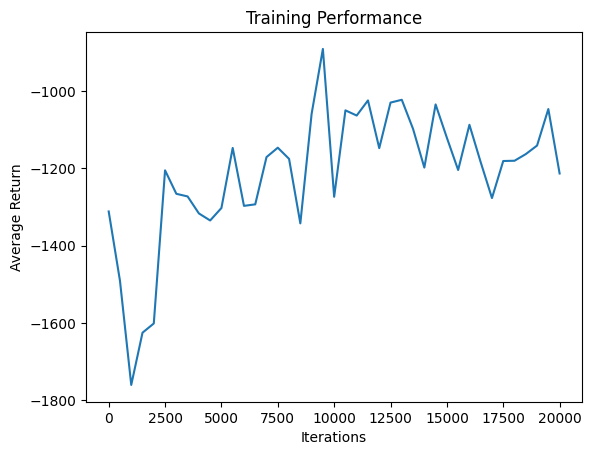

In [33]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.title('Training Performance')
#plt.ylim(top=250)

### Videos

In [34]:
def record_policy_video(env, policy, filename, num_episodes=5, fps=30):
    filename = filename if filename.endswith('.mp4') else filename + '.mp4'
    with imageio.get_writer(filename, fps=fps) as video:
        for episode in range(num_episodes):
            obs, _ = env.reset()
            done = False
            
            # Primer frame
            frame = env.render()
            video.append_data(frame)
            
            while not done:
                obs_tensor = tf.convert_to_tensor([obs], dtype=tf.float32)
                policy_time_step = ts.restart(obs_tensor)
                
                action_step = policy.action(policy_time_step)
                action = action_step.action.numpy()[0]
                
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                
                frame = env.render()
                video.append_data(frame)
    print(f"Video saved to {filename}")

record_policy_video(render_env, agent.policy, "trained_policy.mp4")
record_policy_video(render_env, agent.collect_policy, "random_policy.mp4")


Video saved to trained_policy.mp4
Video saved to random_policy.mp4


In [35]:
print(os.path.abspath("trained_policy.mp4"))

/kaggle/working/trained_policy.mp4


In [36]:
print(os.path.abspath("random_policy.mp4"))

/kaggle/working/random_policy.mp4
